In [85]:
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

NUMBER_OF_STEPS = 2000000
SAMPLE_INTERVAL = 1

length = int(NUMBER_OF_STEPS/SAMPLE_INTERVAL)
x_list = np.zeros(length, dtype=float)
v_list = np.zeros(length, dtype=float)
inv_list = np.zeros(length, dtype=float)

def nhc(M, pos_eta, vel_eta, mas_eta, Ek2, kT, dN, dt2):
    dt4 = dt2 * 0.5
    dt8 = dt4 * 0.5

    # Update velocity of the last (M - 1) thermostat:
    G = vel_eta[M - 2] * vel_eta[M - 2] / mas_eta[M - 2] - kT
    vel_eta[M - 1] += dt4 * G

    # Update thermostat velocities from M - 2 to 0:
    for m in range(M - 2, -1, -1):
        tmp = math.exp(-dt8 * vel_eta[m + 1] / mas_eta[m + 1])
        G = vel_eta[m - 1] * vel_eta[m - 1] / mas_eta[m - 1] - kT
        if m == 0:
            G = Ek2 - dN * kT
        vel_eta[m] = tmp * (tmp * vel_eta[m] + dt4 * G)

    # Update thermostat positions from M - 1 to 0:
    for m in range(M - 1, -1, -1):
        pos_eta[m] += dt2 * vel_eta[m] / mas_eta[m]

    # Compute the scale factor
    factor = math.exp(-dt2 * vel_eta[0] / mas_eta[0])

    # Update thermostat velocities from 0 to M - 2:
    for m in range(M - 1):
        tmp = math.exp(-dt8 * vel_eta[m + 1] / mas_eta[m + 1])
        G = vel_eta[m - 1] * vel_eta[m - 1] / mas_eta[m - 1] - kT
        if m == 0:
            G = Ek2 * factor * factor - dN * kT
        vel_eta[m] = tmp * (tmp * vel_eta[m] + dt4 * G)

    # Update velocity of the last (M - 1) thermostat:
    G = vel_eta[M - 2] * vel_eta[M - 2] / mas_eta[M - 2] - kT
    vel_eta[M - 1] += dt4 * G

    return factor


# Main simulation loop
dN = 1.0
dt = 0.01
dt2 = dt * 0.5
kT = 1.0
x = 1.0
v = 1.0
mass = 1.0
k_spring = 1.0
f = -k_spring * x
M = 4
tau = dt * 100
pos_eta = [0.0] * M
vel_eta = [0.0] * M
mas_eta = [0.0] * M

vel_eta[0] = vel_eta[2] = +1.0
vel_eta[1] = vel_eta[3] = -1.0

for i in range(M):
    pos_eta[i] = 0.0
    mas_eta[i] = kT * tau * tau
    if i == 0:
        mas_eta[i] = dN * kT * tau * tau

Ek2 = 0.0
factor = 0.0


for step in tqdm(range(NUMBER_OF_STEPS)):
    inv = mass * v * v * 0.5 + k_spring * x * x * 0.5
    inv += kT * dN * pos_eta[0]

    for m in range(1, M):
        inv += kT * pos_eta[m]

    for m in range(M):
        inv += 0.5 * vel_eta[m] * vel_eta[m] / mas_eta[m]

    if step % SAMPLE_INTERVAL == 0:
        nn = int(step/SAMPLE_INTERVAL)
        x_list[nn] = x
        v_list[nn] = v
        inv_list[nn] = inv

    Ek2 = v * v * mass
    factor = nhc(M, pos_eta, vel_eta, mas_eta, Ek2, kT, dN, dt2)
    v *= factor

    v += dt2 * (f / mass)
    x += dt * v
    f = -k_spring * x
    v += dt2 * (f / mass)

    Ek2 = v * v * mass
    factor = nhc(M, pos_eta, vel_eta, mas_eta, Ek2, kT, dN, dt2)
    v *= factor

100%|██████████| 2000000/2000000 [00:23<00:00, 84373.47it/s]


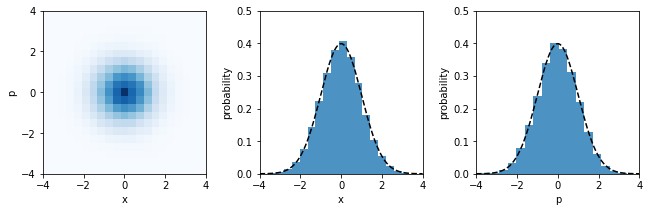

In [108]:
fig, axs = plt.subplots(1, 3)
axs[0].hist2d(x_list, v_list, bins=21, range=[[-4, 4], [-4, 4]], cmap="Blues")
axs[0].set_xlim(-4, 4)
axs[0].set_ylim(-4, 4)
axs[0].set_xlabel("x")
axs[0].set_ylabel("p")
axs[0].set_xticks([-4, -2, 0, 2, 4])
axs[0].set_yticks([-4, -2, 0, 2, 4])
axs[0].set_aspect(1)

position = np.linspace(-4, 4, 500)
boltz_factor = np.exp(-0.5/kT*k_spring*position**2)
Z = np.trapz(boltz_factor, position)
boltz_factor /= Z
axs[1].plot(position, boltz_factor, color="k", linestyle="--")
axs[2].plot(position, boltz_factor, color="k", linestyle="--")

axs[1].hist(x_list, density=True, bins=21, alpha=0.8)
axs[1].set_xlim(-4, 4)
axs[1].set_ylim(0, 0.5)
axs[1].set_box_aspect(1)
axs[1].set_xlabel("x")
axs[1].set_ylabel("probability")
axs[1].set_xticks([-4, -2, 0, 2, 4])

axs[2].hist(v_list, density=True, bins=21, alpha=0.8)
axs[2].set_xlim(-4, 4)
axs[2].set_ylim(0, 0.5) 
axs[2].set_box_aspect(1)
axs[2].set_xlabel("p")
axs[2].set_ylabel("probability")
axs[2].set_xticks([-4, -2, 0, 2, 4])

fig.set_size_inches(11, 3)
plt.savefig("md_ho_nhc.pdf", bbox_inches="tight")
plt.show()